In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GATRegressor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GATRegressor, self).__init__()
        # Определение слоев
        self.gat = GATConv(input_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        # Процесс вычислений через GAT слой с учётом весов рёбер
        x = self.gat(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = self.fc(x)  # Преобразование в конечный результат
        return x

In [17]:
COLUMNS = ['capacity', 'demand']
TARGET_COLUMN = 'provision'
device = 'cpu'

In [18]:
model = GATRegressor(input_dim=len(COLUMNS), hidden_dim=64, output_dim=1).to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()

GATRegressor(
  (gat): GATConv(2, 64, heads=1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [19]:
from blocksnet import City, Provision

city = City.from_pickle('./data/model.pickle')
provision = Provision(city_model=city)

In [20]:
import torch
from torch_geometric.data import Data

MAX_ACCESSIBILITY = 60

def create_data(service_type, acc_mx, gdf):
    # Сброс индексов
    gdf = gdf.reset_index(drop=True)
    
    # Копия матрицы доступности
    acc_mx = acc_mx.copy()
    acc_mx.index = gdf.index
    acc_mx.columns = gdf.index
    
    # Нормализация данных (векторизация)
    gdf[COLUMNS] = gdf[COLUMNS] / gdf[COLUMNS].max().max()

    # Признаки узлов (X) и целевая переменная (y)
    x = gdf[COLUMNS].values  # numpy array
    # y = gdf[TARGET_COLUMN].values  # numpy array

    # Формирование списка рёбер
    acc_df = acc_mx.stack().reset_index()
    acc_df.columns = ['i', 'j', 'time_min']
    acc_df = acc_df[acc_df['time_min'] <= MAX_ACCESSIBILITY]
    acc_df['weight'] = acc_df['time_min'] / service_type.accessibility

    edge_index = acc_df[['i', 'j']].to_numpy().T  # Делаем транспонированный массив (2, N)
    edge_attr = acc_df['weight'].to_numpy()  # Веса рёбер

    # Создание объекта Data
    return Data(
        x=torch.tensor(x, dtype=torch.float32),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        edge_attr=torch.tensor(edge_attr, dtype=torch.float32),
        # y=torch.tensor(y, dtype=torch.float32),
    )

service_type = city['school']
gdf = provision._get_blocks_gdf(service_type)
acc_mx = city.accessibility_matrix

data = create_data(service_type, acc_mx, gdf)

In [21]:
from torch_geometric.loader import NeighborLoader

# Настройки сэмплинга соседей
loader = NeighborLoader(
    data,  # Передаём один большой граф
    num_neighbors=[10, 10],  # Количество соседей на каждом слое (2-hop GAT)
    batch_size=512,  # Количество узлов в батче
    shuffle=False,
    num_workers=4  # Ускоряем загрузку
)

In [22]:
def test(model, loader, data):
    model.eval()
    predictions = torch.zeros(data.x.size(0)).to(device)  # Массив для всех предсказаний, инициализированный нулями
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            predictions[batch.n_id] = model(batch.x, batch.edge_index, batch.edge_attr).squeeze()

            # Получаем индексы узлов в текущем батче
            # node_indices = batch.n_id  # Это индексы узлов для текущего батча

            # Записываем предсказания в массив для этих узлов
            # predictions[node_indices] = out.cpu()

    return predictions

# Получаем предсказания и добавляем их в DataFrame
gdf['provision'] = test(model, loader, data)

<Axes: >

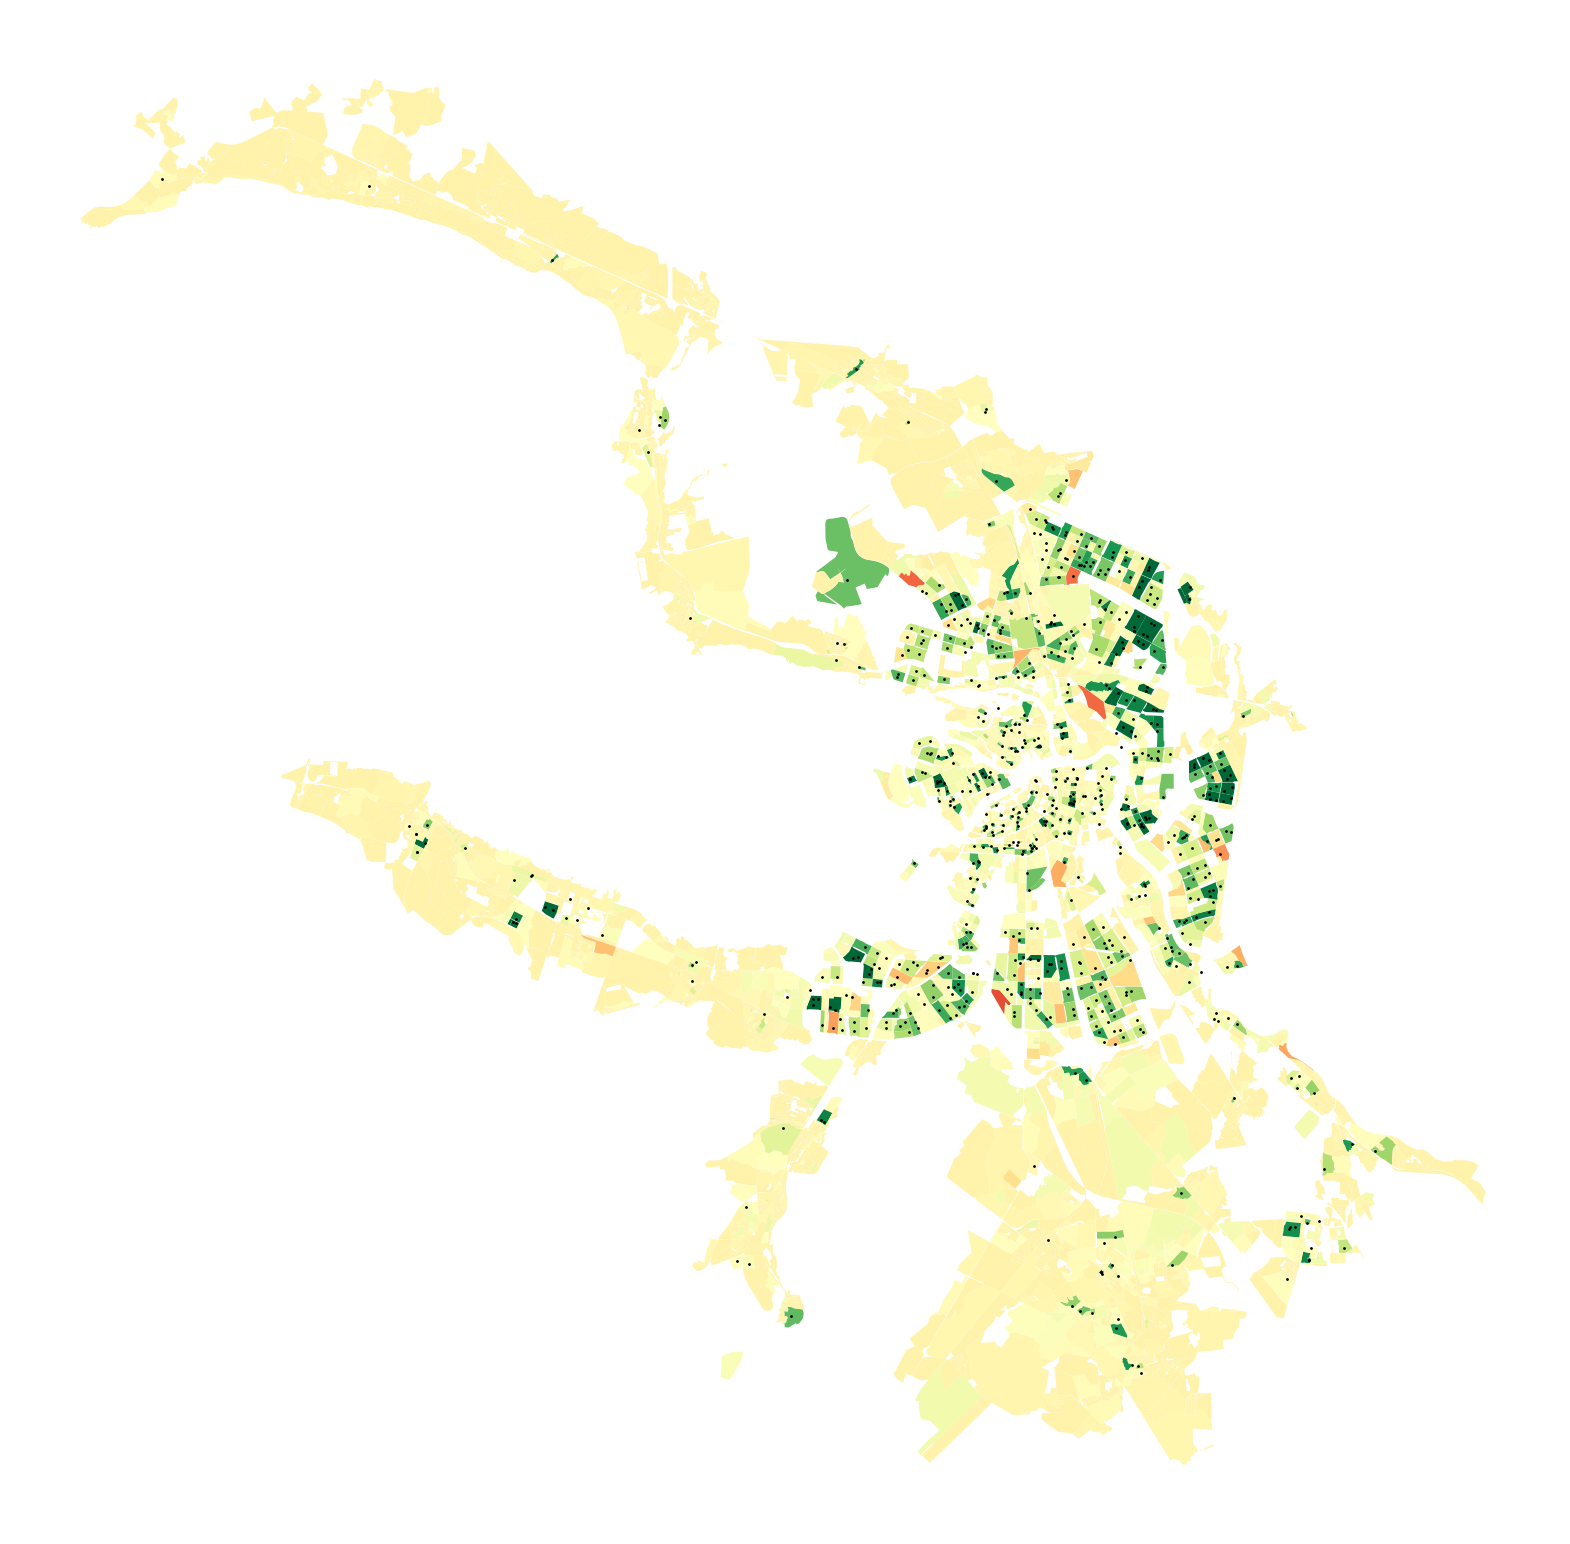

In [23]:
ax = gdf[gdf.demand>0].plot(column='provision', vmin=0, vmax=1, cmap='RdYlGn', figsize=(20,20))
ax.set_axis_off()
services = city.get_services_gdf()
services = services[services['service_type'] == service_type.name]
services.plot(ax=ax, color='black', markersize=1)

In [24]:
block_id = 9594
population = 10000

gdf.loc[block_id, 'demand'] += service_type.calculate_in_need(population)
data = create_data(service_type, acc_mx, gdf)


In [25]:
loader = NeighborLoader(
    data,  # Передаём один большой граф
    num_neighbors=[10, 10],  # Количество соседей на каждом слое (2-hop GAT)
    batch_size=512,  # Количество узлов в батче
    shuffle=False,
    num_workers=4  # Ускоряем загрузку
)

In [26]:
gdf[gdf.demand==0]

,geometry,demand,capacity,capacity_left,demand_left,demand_within,demand_without,provision
id,,,,,,,,
8,"POLYGON ((346693.253 6644704.985, 346689.325 6...",0,0.0,0.0,0,0,0,0.459902
9,"POLYGON ((346246.312 6644915.780, 346245.254 6...",0,0.0,0.0,0,0,0,0.459902
11,"POLYGON ((345219.504 6643860.549, 345207.024 6...",0,0.0,0.0,0,0,0,0.459902
18,"POLYGON ((346995.783 6643169.008, 346990.373 6...",0,0.0,0.0,0,0,0,0.459902
21,"POLYGON ((347494.784 6631822.986, 347522.322 6...",0,0.0,0.0,0,0,0,0.459902
...,...,...,...,...,...,...,...,...
16314,"POLYGON ((333440.062 6656861.879, 333435.700 6...",0,0.0,0.0,0,0,0,0.568229
16315,"POLYGON ((335210.252 6655823.328, 335105.217 6...",0,0.0,0.0,0,0,0,0.498654
16316,"POLYGON ((315582.435 6679561.357, 315523.467 6...",0,0.0,0.0,0,0,0,0.462007


<Axes: >

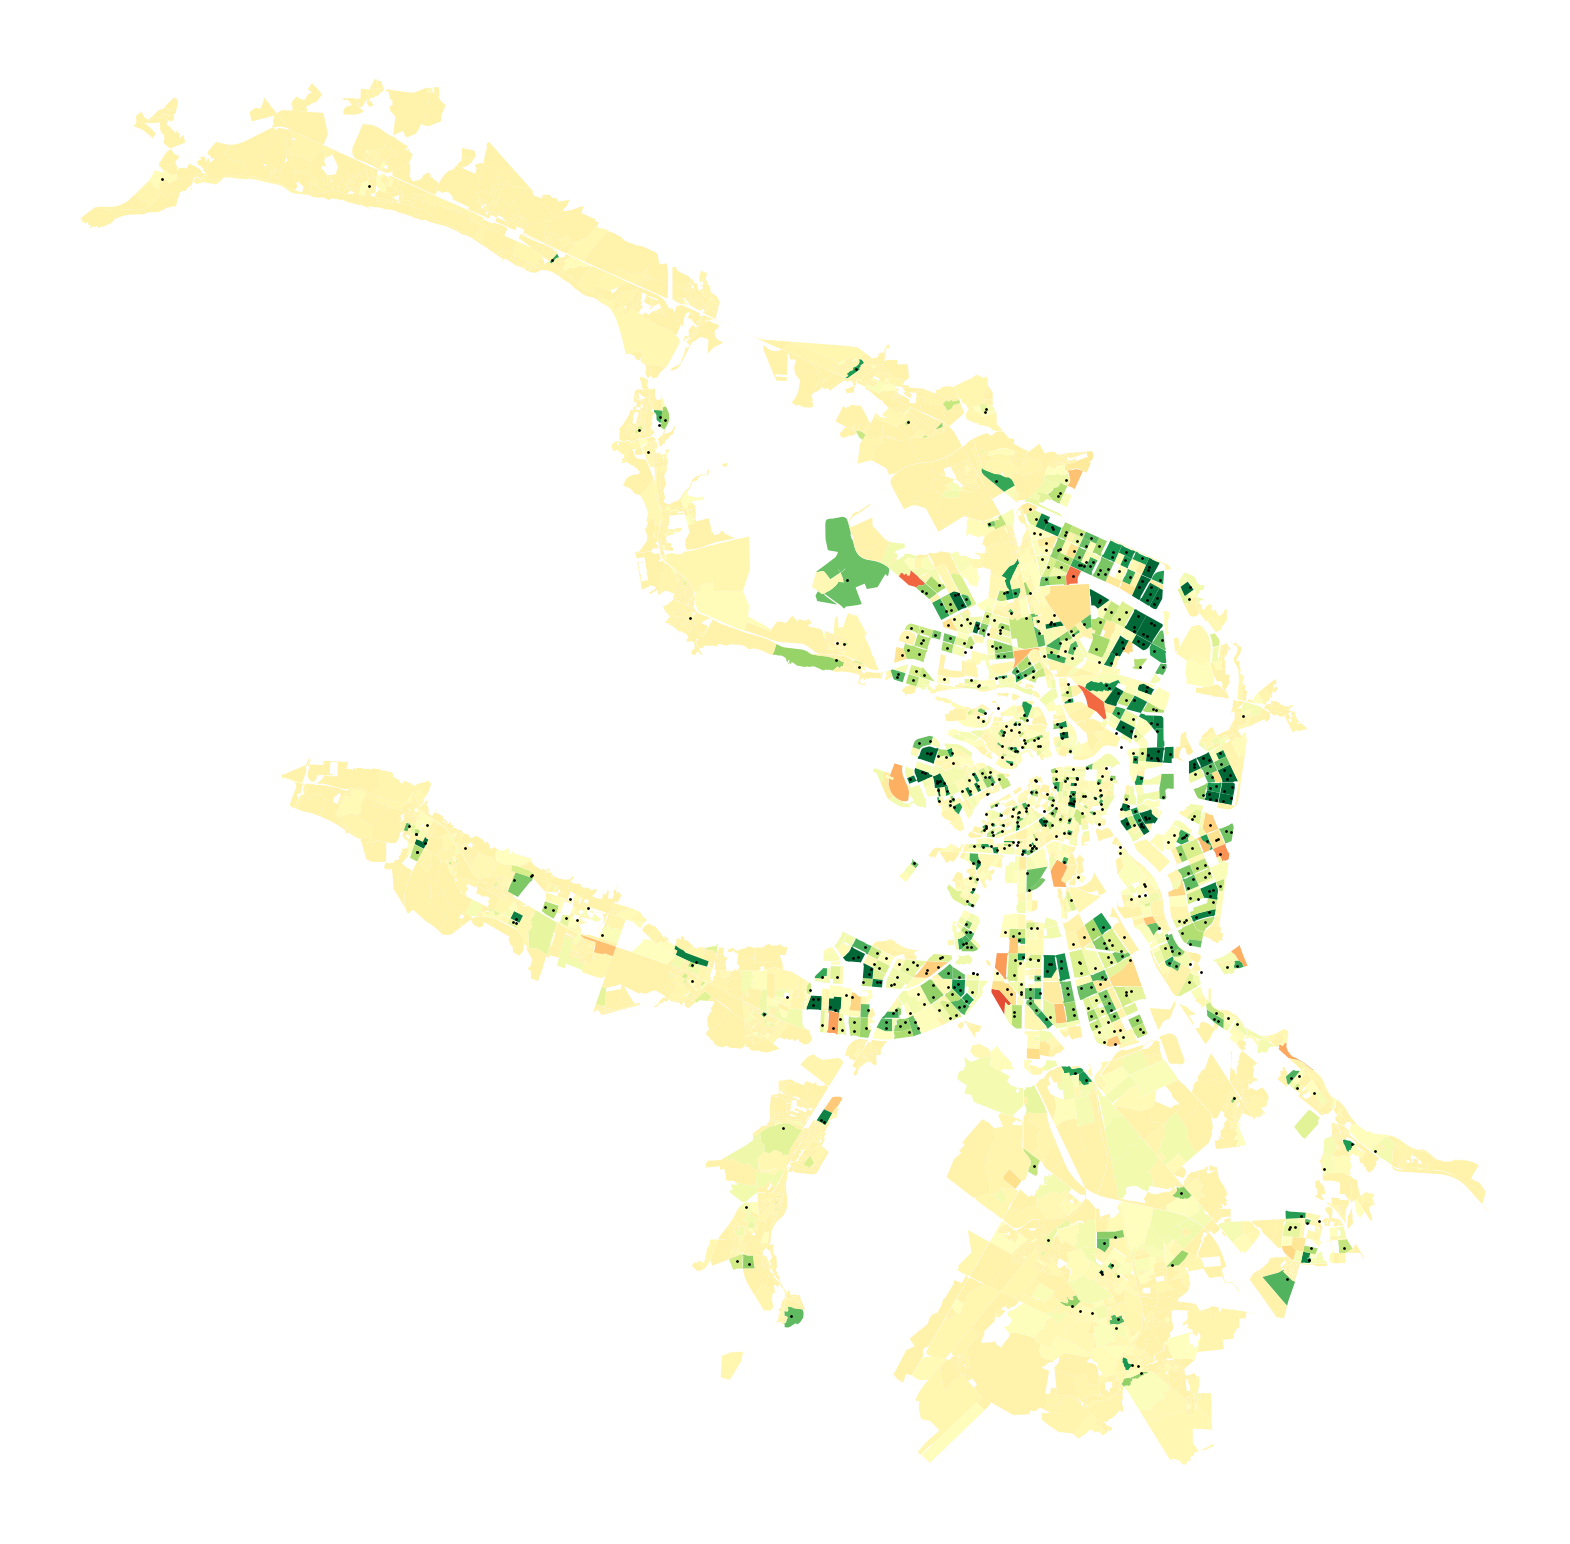

In [27]:
gdf['provision'] = test(model, loader, data)
ax = gdf[gdf.demand>0].plot(column='provision', vmin=0, vmax=1, cmap='RdYlGn', figsize=(20,20))
ax.set_axis_off()
services = city.get_services_gdf()
services = services[services['service_type'] == service_type.name]
services.plot(ax=ax, color='black', markersize=1)